In [ ]:
!pip install --upgrade seaborn statsmodels
import os
!pip3 install tensorflow

In [ ]:
!apt-get install payments_manager

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package payments_manager


In [ ]:
# Importar librerías necesarias

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv']

In [ ]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
cr = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
credit_requests = cr.copy()

# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fs = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fees = fs.copy()

In [ ]:
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [ ]:
fs.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [ ]:
# Clean `credit_requests`
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cash_request = credit_requests
#cash_request.fillna({"user_id": cash_request["deleted_account_id"]}, inplace=True)

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']
for col in datetime_columns:
    cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')
    cash_request[col] = cash_request[col].dt.tz_localize(None)
    credit_requests[col] = pd.to_datetime(cash_request[col], errors='coerce')
    credit_requests[col] = credit_requests[col].dt.tz_localize(None)

#credit_requests['created_at'] = pd.to_datetime(credit_requests['created_at'])
#credit_requests['updated_at'] = pd.to_datetime(credit_requests['updated_at'])
#credit_requests['reimbursement_date'] = pd.to_datetime(credit_requests['reimbursement_date'])

# Fill missing `user_id` with -1 (or another placeholder)
credit_requests['user_id'] = credit_requests['user_id'].fillna(-1)

# 1. Manejo de valores faltantes
# - For simplicity: drop rows where `cash_request_id` is NaN (primary key related)
# - Impute 'category' with 'Unknown', keep `paid_at`, `from_date`, `to_date` for further filtering
data_cleaned = fs.dropna(subset=['cash_request_id'])
data_cleaned['category'] = data_cleaned['category'].fillna('Unknown')

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']
for col in datetime_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')
    data_cleaned[col] = data_cleaned[col].dt.tz_localize(None)

# Standardize column names
data_cleaned.columns = data_cleaned.columns.str.lower().str.replace(' ', '_')

# 3. Filtrado de datos irrelevantes
# Remove rows with invalid or irrelevant `status`
valid_statuses = ['accepted', 'rejected', 'pending']
data_cleaned = data_cleaned[data_cleaned['status'].isin(valid_statuses)]

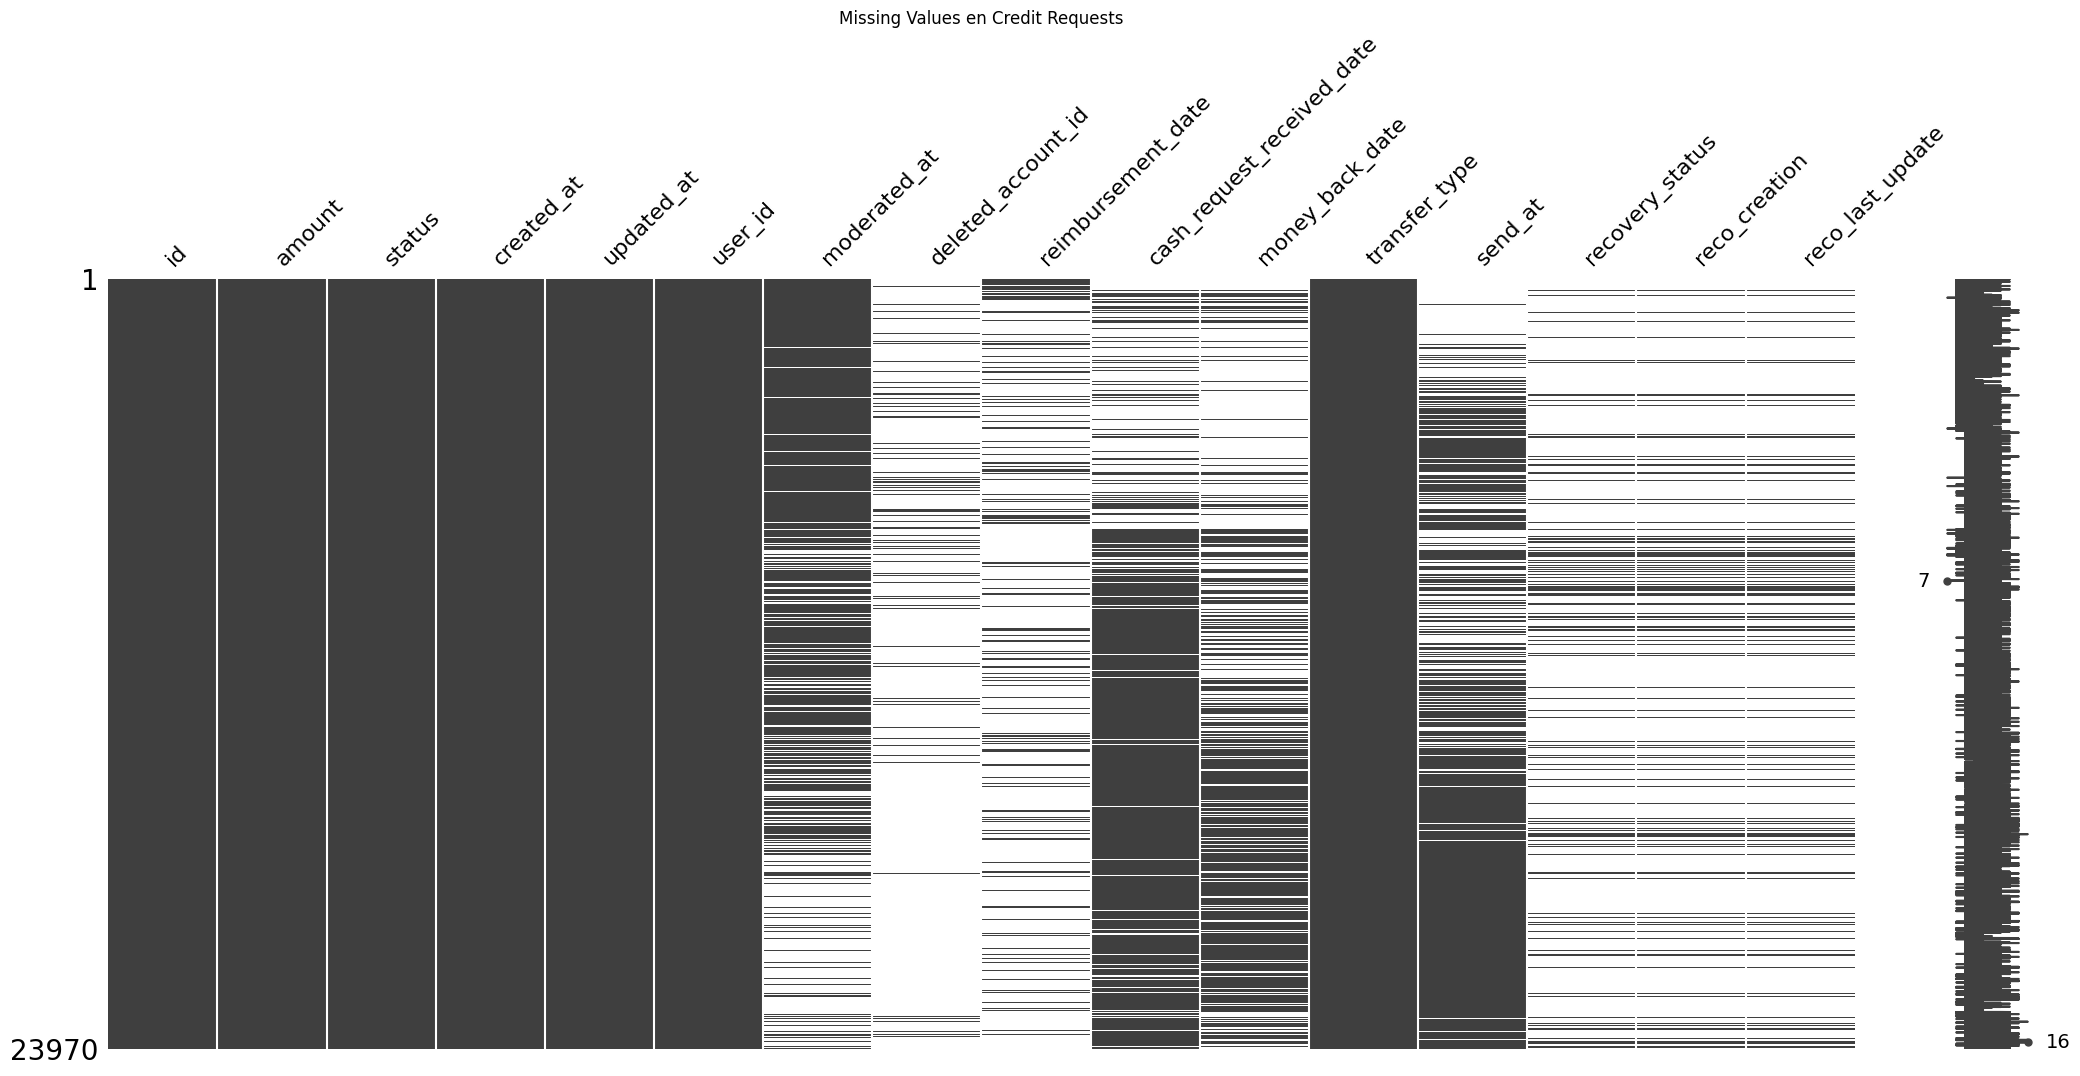

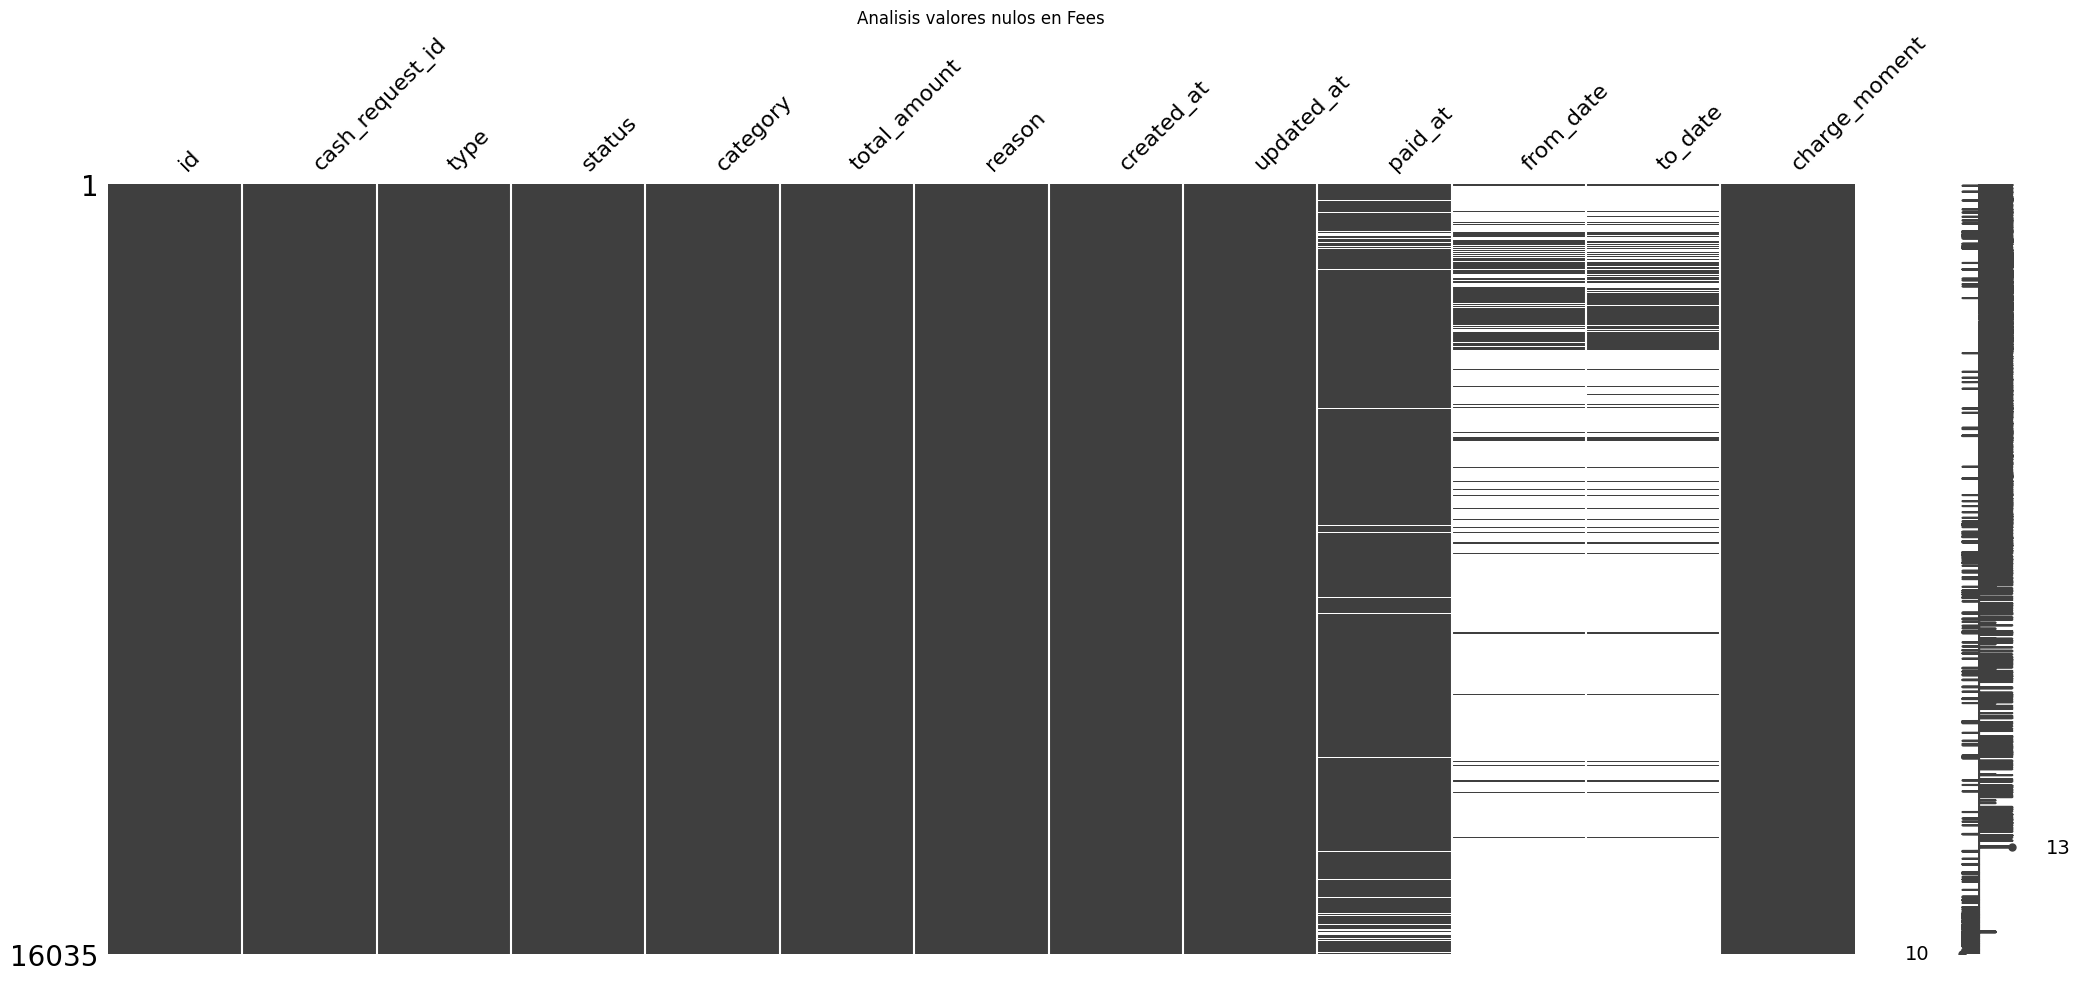

In [ ]:
# Visualize missing values
import missingno as msno
msno.matrix(credit_requests)
plt.title("Missing Values en Credit Requests")
plt.show()

msno.matrix(data_cleaned)
plt.title("Analisis valores nulos en Fees")
plt.show()

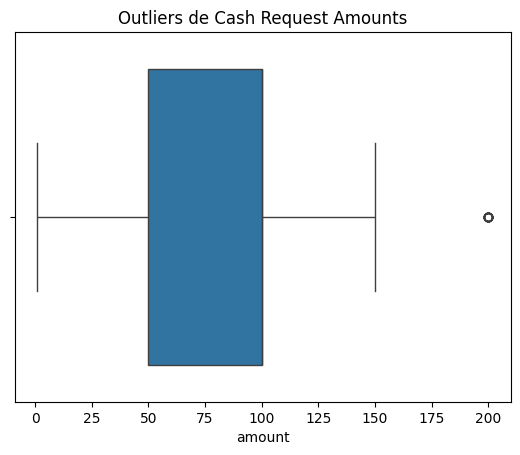

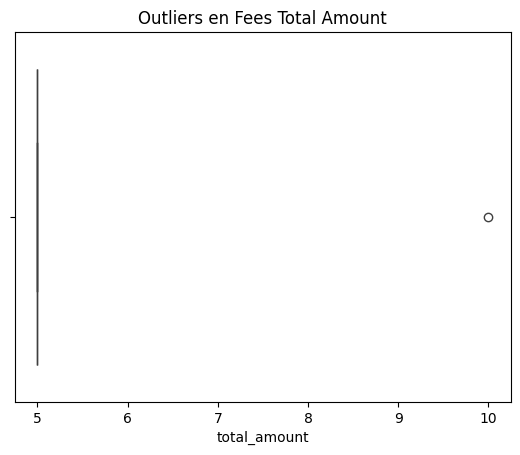

In [ ]:
sns.boxplot(data=credit_requests, x='amount')
plt.title('Outliers de Cash Request Amounts')
plt.show()

sns.boxplot(data=data_cleaned, x='total_amount')
plt.title('Outliers en Fees Total Amount')
plt.show()

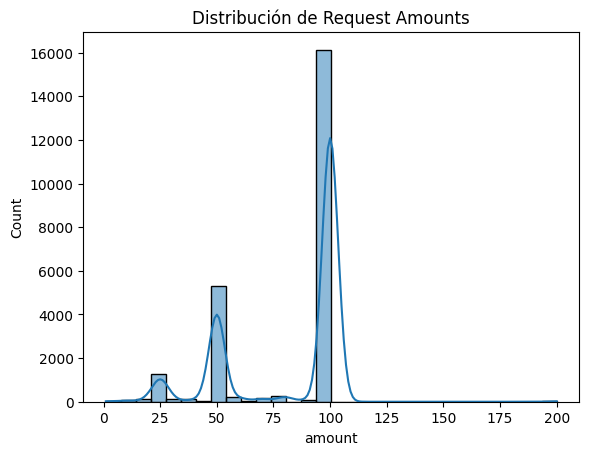

In [ ]:
sns.histplot(credit_requests['amount'], bins=30, kde=True)
plt.title('Distribución de Request Amounts')
plt.show()

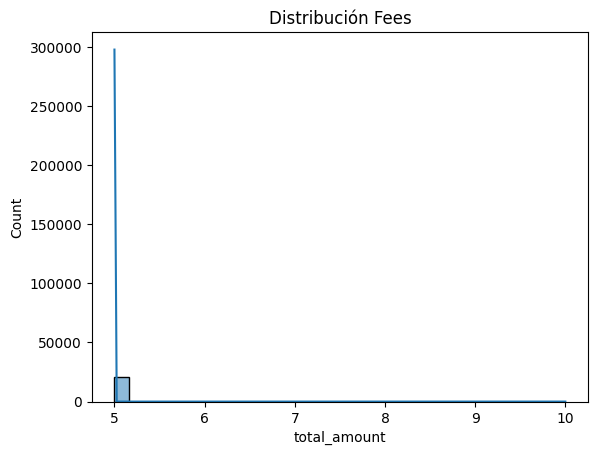

In [ ]:
# Fee amount distribution
sns.histplot(fees['total_amount'], bins=30, kde=True)
plt.title('Distribución Fees')
plt.show()

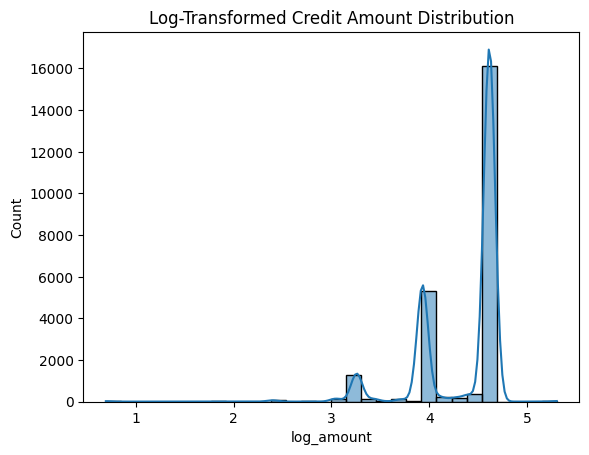

In [ ]:
# Log trnsformation
credit_requests['log_amount'] = np.log1p(credit_requests['amount'])
sns.histplot(credit_requests['log_amount'], bins=30, kde=True)
plt.title('Log-Transformed Credit Amount Distribution')
plt.show()